In [1]:

import os
import gc
import numpy as np  
import scanpy as sc
import pandas as pd

from conformalSC_annotator import  ConformalSCAnnotator



query_data_path = 'test_data\GSE178360\GSE178360_immune.h5ad'
adata_query = sc.read_h5ad(query_data_path) 

## This is te expected input data: ##

X = adata_query.X.astype(np.float32)                        # data matrix (cells x genes)
var_query_list = adata_query.var["features"].tolist()       # This is the case of the list
#var_query_df = pd.DataFrame({'features':var_query_list })  # Unncomment for testing. This is the case of the df
obs_query = adata_query.obs                                 # not needed, for ground thruth test

     


c:\Users\Marcos\anaconda3\envs\conformals\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\Marcos\anaconda3\envs\conformals\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
annotator = ConformalSCAnnotator(X, var_query_list, obs_query) # obs_query is optional, it will be used for annotate the predicted cells. 

annotator.quality_control()  ## This is an optional step to do a basic preprocess the data. If the data is already preprocessed, this step is optional.

annotator.configure(model = "HumanLung_TopMarkersFC_level3",
                        CP_predictor = "mondrian",                        # mondrian or cluster
                        cell_type_level = "celltype_level3",              # lineage_level2   celltype_level3
                        cell_types_excluded_treshold = 50,                  # Exclude cell types with less than 50 cells
                        test = True,                                      # Perform internal validation
                        alpha = [0.01, 0.05, 0.1],
                        epoch=20,
                        batch_size = 525)  
    

# annotate your data to a given significance level
annotator.annotate(batch_correction="combat")  # batch_correction = "combat" or "harmony" or "mnn" or False


Succesfully generated object:  (9468, 30555)
Filtering low quality cells...
Filtered! Post-QC shape:  (9468, 30555)
Model not trained yet. Fitting the model first.
Loading reference data...
Reference data loaded.
Detecting common genes...
Common genes detected: 1140
Running integration....
Data integrated!

Label distribution:
celltype_level3
AM                        95610
AT2                       56383
iMON                      17253
CAP1                      14696
Suprabasal                11162
AT1                       10137
Ciliated                   9629
NK                         8686
Basal                      7635
CAP2                       6985
IM                         5888
CD4_T                      5515
AF1                        4844
VEC                        4514
SVEC                       4269
RAS                        3999
AEC                        3974
Serous                     3329
LEC                        3281
CD8_T                      3170
B              

In [3]:
# Get the predictions returning the observations of the query data object
print("\nPredicted annotations sets: \n" , annotator.adata_query.obs)

    
ground_truth_labels_list = obs_query["cell_type"].tolist()
annotator.recover_original_cells( ground_truth_labels_list, similarity_threshold=70)


y_true = annotator._mapped_original_ground_truth_labels ## Ground thruth labels mapped to the model labels (predictions)
#annotator._mapping


results = []
for pred,cp_pred_001,cp_pred_005, cp_pred_010, true, o_g_t in zip(
        annotator.adata_query.obs["predicted_labels"],
        annotator.adata_query.obs["prediction_sets_0.01"],
        annotator.adata_query.obs["prediction_sets_0.05"],
        annotator.adata_query.obs["prediction_sets_0.1"],
        y_true,
         ground_truth_labels_list):
        
    print(f"Predicted: {pred} - CP 0.01: {cp_pred_001} - CP 0.05: {cp_pred_005} - CP 0.10: {cp_pred_010} - True: {true}. original cell Subt: {o_g_t}")
        
    results.append({
        "Predicted": pred,
        "CP 0.01": cp_pred_001,
        "CP 0.05": cp_pred_005,
        "CP 0.1": cp_pred_010,
        "True": true,
        "Original_Cell_Subtype": o_g_t
    })
    
df_results = pd.DataFrame(results)
df_results.to_csv("saves/results_immune.csv", index=False)  # Save to CSV if needed


Predicted annotations sets: 
                                orig.ident    nCount_RNA  nFeature_RNA  \
AAACCCAAGCCTCTGG-1_1-query  SeuratProject  16767.370165          4221   
AAACCCAAGTCAAGCG-1_1-query  SeuratProject   4690.669529          1761   
AAACCCACACTGTTCC-1_1-query  SeuratProject   4061.650062          1830   
AAACGCTAGTACCCTA-1_1-query  SeuratProject   4045.692015          1351   
AAACGCTTCCCGAATA-1_1-query  SeuratProject  36168.795726          2745   
...                                   ...           ...           ...   
GTGGAAGTCCATAGAC-1_3-query  SeuratProject   3537.660464          1564   
TACTTCAGTAATTGGA-1_3-query  SeuratProject   2172.917685          1063   
TCATGCCGTGGTCCCA-1_3-query  SeuratProject   2792.173999          1405   
TGACGCGGTCGAATTC-1_3-query  SeuratProject   4764.288856          1625   
TTTACCATCATTCACT-1_3-query  SeuratProject   3499.206924          1255   

                            nCount_SCT  nFeature_SCT  S.Score  G2M.Score  \
AAACCCAAGCCTCTGG

In [4]:
df_results.head(10)

Predicted                                            CP 0.01  \
0        IM                                               [IM]   
1      CAP2  [AEC, AF1, AF2, AM, Basal, CAP1, CAP2, CD4_T, ...   
2        NK  [AEC, AF1, AM, B, Basal, CAP1, CAP2, CD4_T, CD...   
3     CD4_T  [AEC, AF1, AF2, AM, AT1, AT2, B, Basal, CAP1, ...   
4    Plasma                                           [Plasma]   
5     CD4_T  [AF2, AT2, B, Basal, CD4_T, IM, LEC, Pericyte,...   
6        IM                                               [IM]   
7        NK  [AF1, AM, Basal, CAP1, CAP2, CD4_T, CD8_T, Gob...   
8      pMON                                       [iMON, pMON]   
9      iMON                                             [iMON]   

                                             CP 0.05  \
0                                               [IM]   
1  [AEC, AF1, AM, CAP1, CAP2, CD8_T, NK, Pericyte...   
2  [AEC, AM, CAP1, CAP2, CD4_T, CD8_T, Goblet, LE...   
3  [AF1, AF2, AM, AT2, B, CAP1, CD4_T, CD8_T, Cil...   
4                                           [Plasma]   
5                                            [CD4_T]   
6                                               [IM]   
7                                    [AM, CD8_T, NK]   
8                                             [pMON]   
9                                             [iMON]   

                                              CP 0.1    True  \
0                                               [IM]     OOD   
1                   [AF1, AM, CAP1, CAP2, CD8_T, NK]   CD8_T   
2  [AEC, AM, CAP1, CAP2, CD8_T, NK, SVEC, Supraba...     OOD   
3  [AF2, AM, B, CAP1, CD4_T, CD8_T, Ciliated, IM,...   CD4_T   
4                                           [Plasma]  Plasma   
5                                                 []   CD4_T   
6                                               [IM]     OOD   
7                                               [NK]     OOD   
8                                             [pMON]     OOD   
9                                             [iMON]     OOD   

   Original_Cell_Subtype  
0              Dendritic  
1                 CD8+ T  
2         Natural Killer  
3                 CD4+ T  
4                 Plasma  
5                 CD4+ T  
6              Dendritic  
7         Natural Killer  
8  Nonclassical Monocyte  
9     Classical Monocyte

In [5]:
df_results['Original_Cell_Subtype'].value_counts()

Original_Cell_Subtype
Natural Killer           1984
Nonclassical Monocyte    1414
CD4+ T                   1360
Classical Monocyte       1102
CD8+ T                   1024
Dendritic                 878
Basophil/Mast             522
Macrophage                448
B                         351
Plasma                    146
Proliferating NK/T         78
Proliferating Immune       67
Neutrophil                 53
Platelet                   41
Name: count, dtype: int64

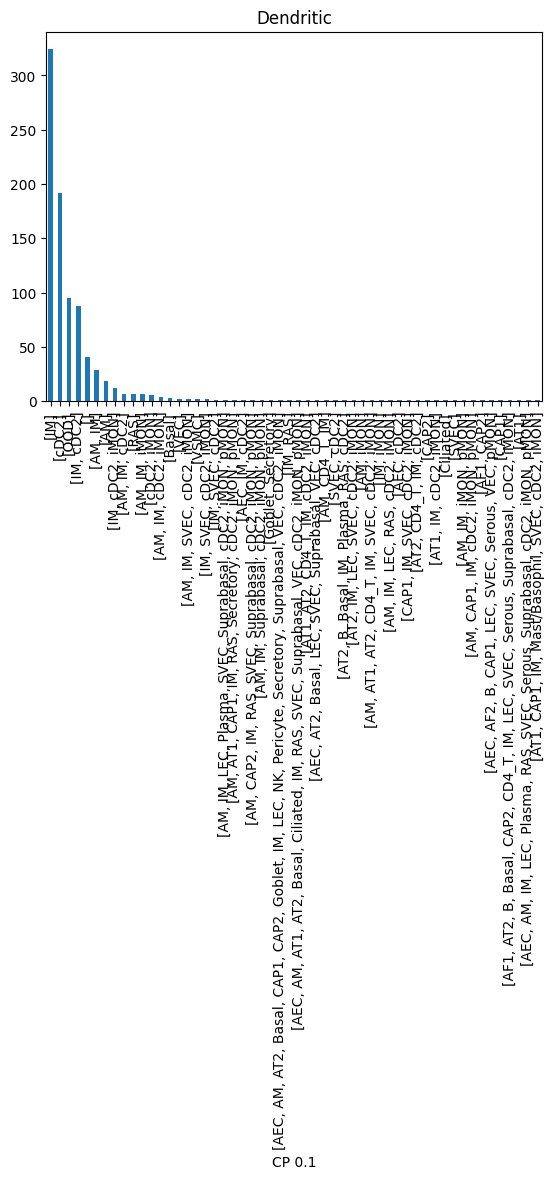

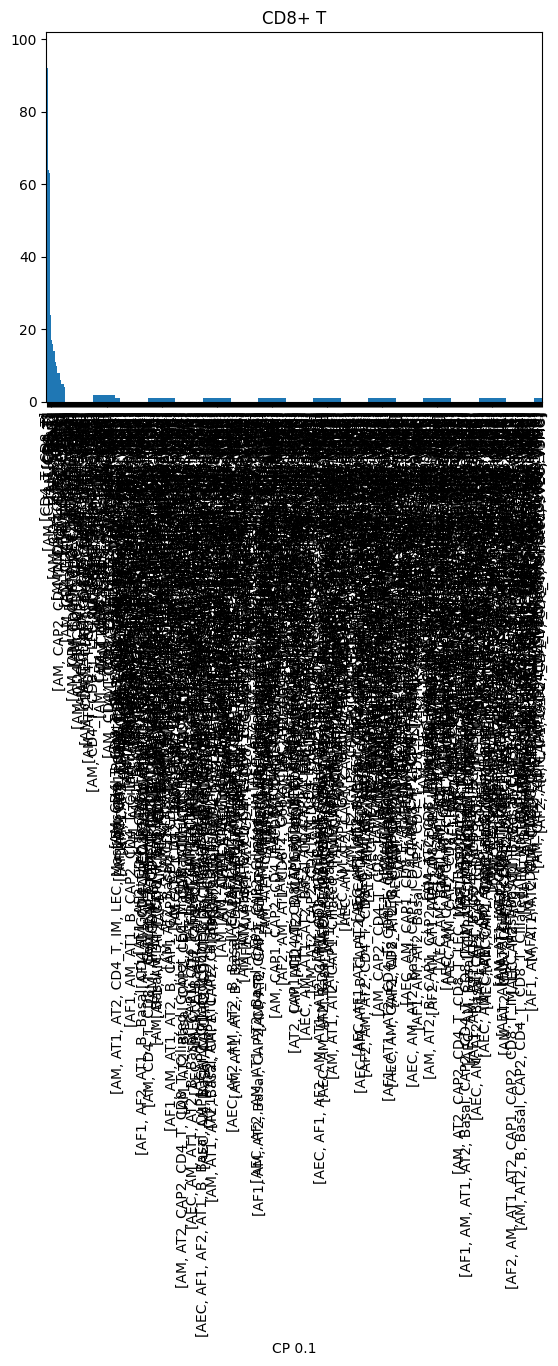

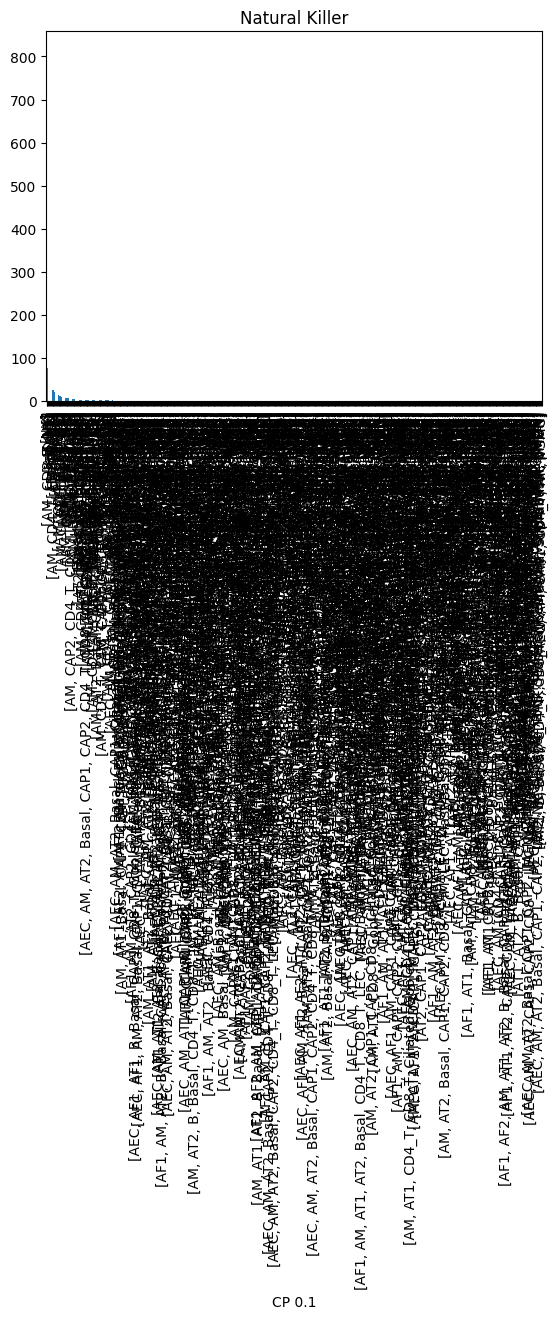

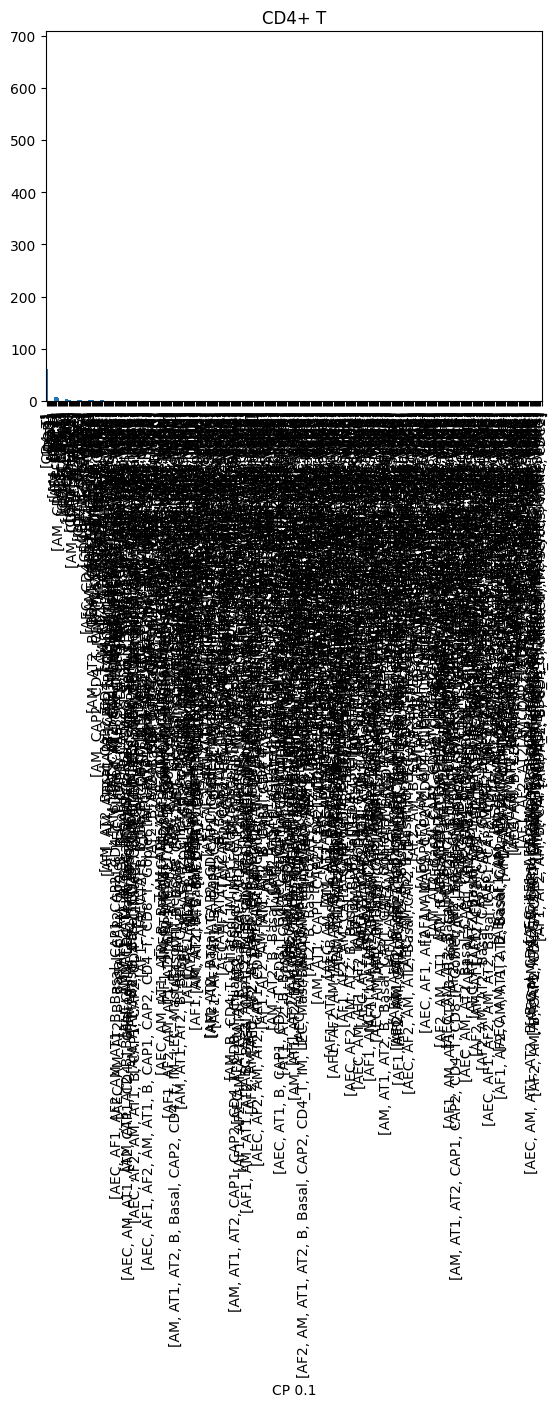

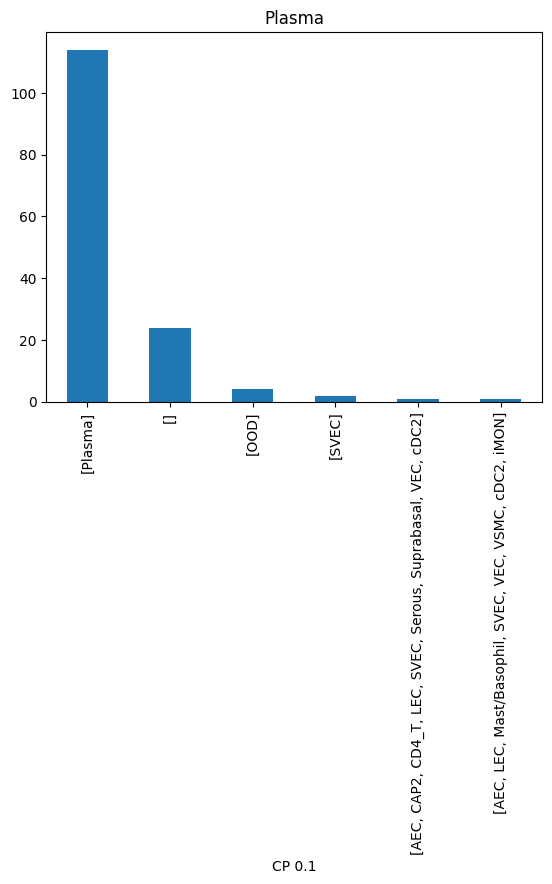

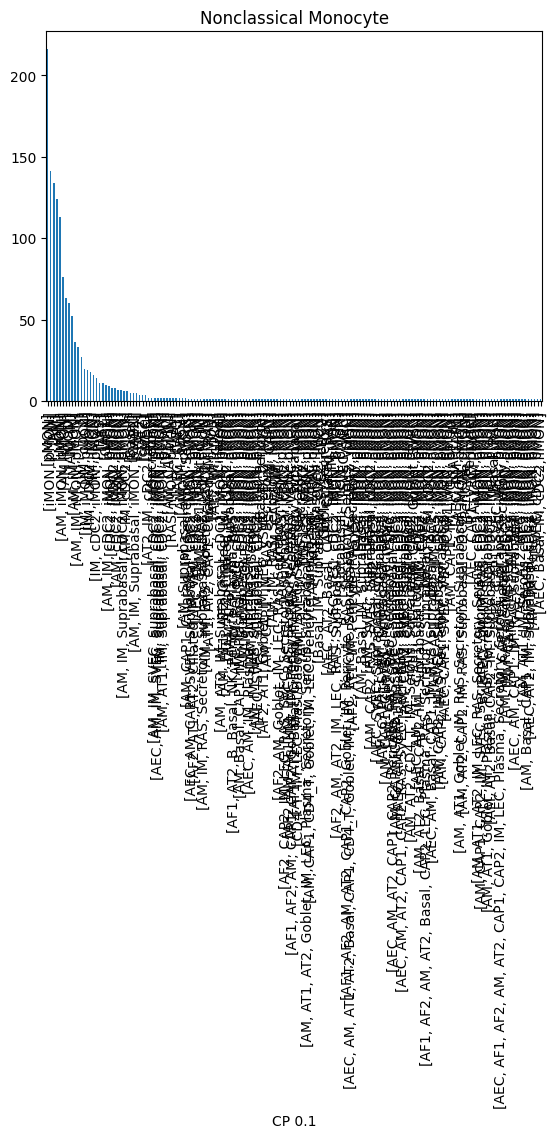

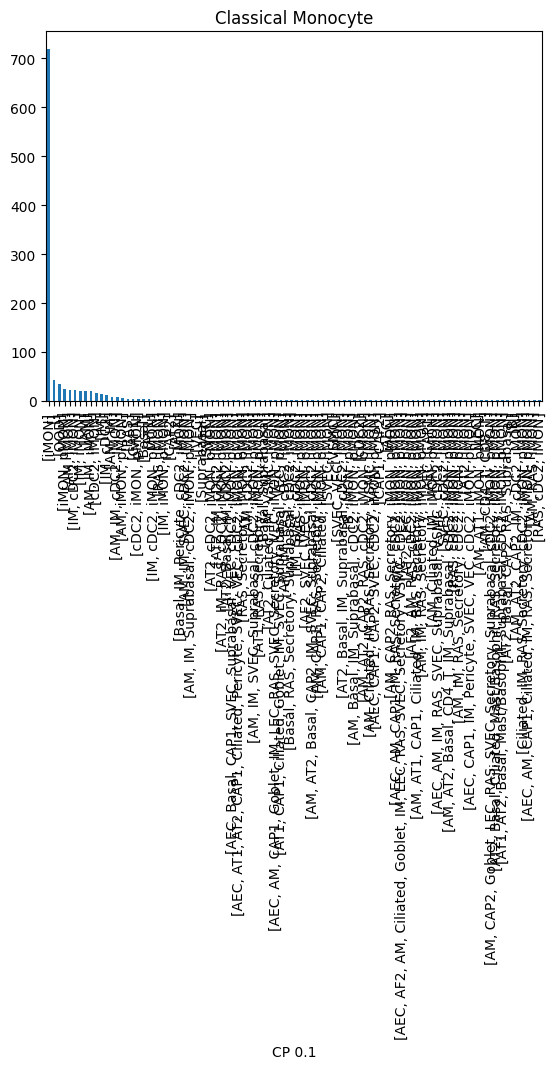

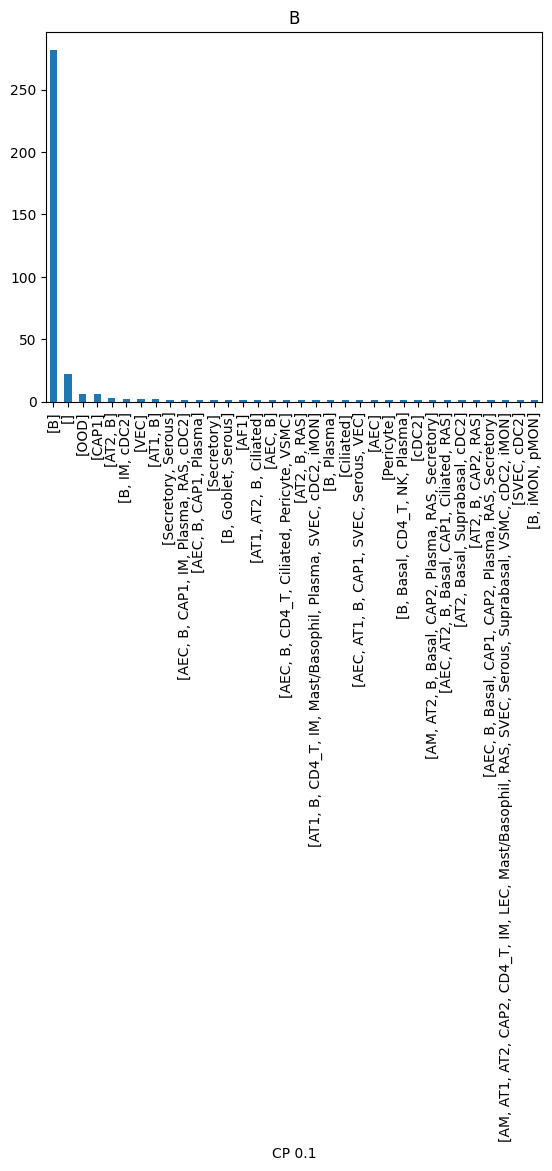

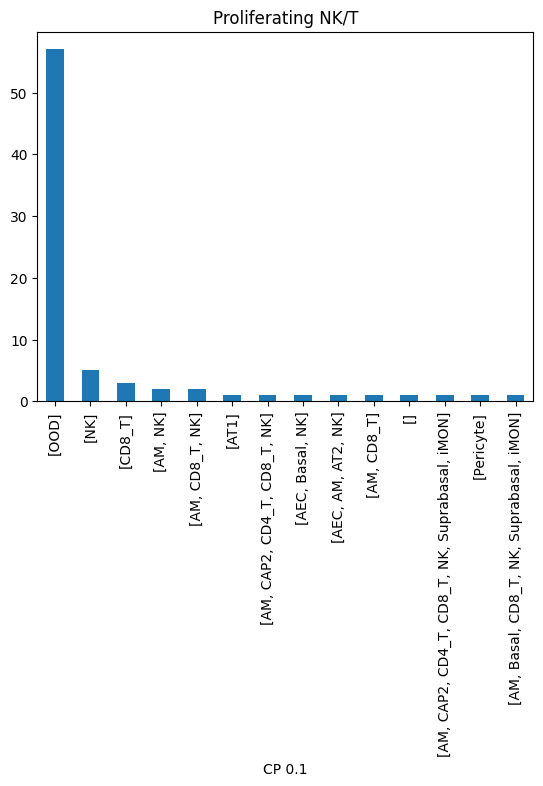

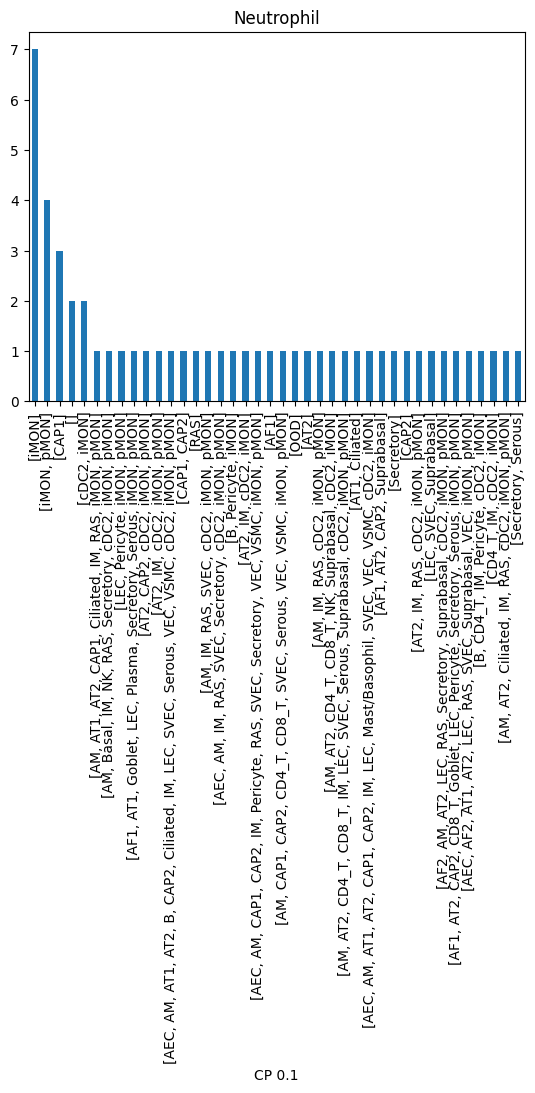

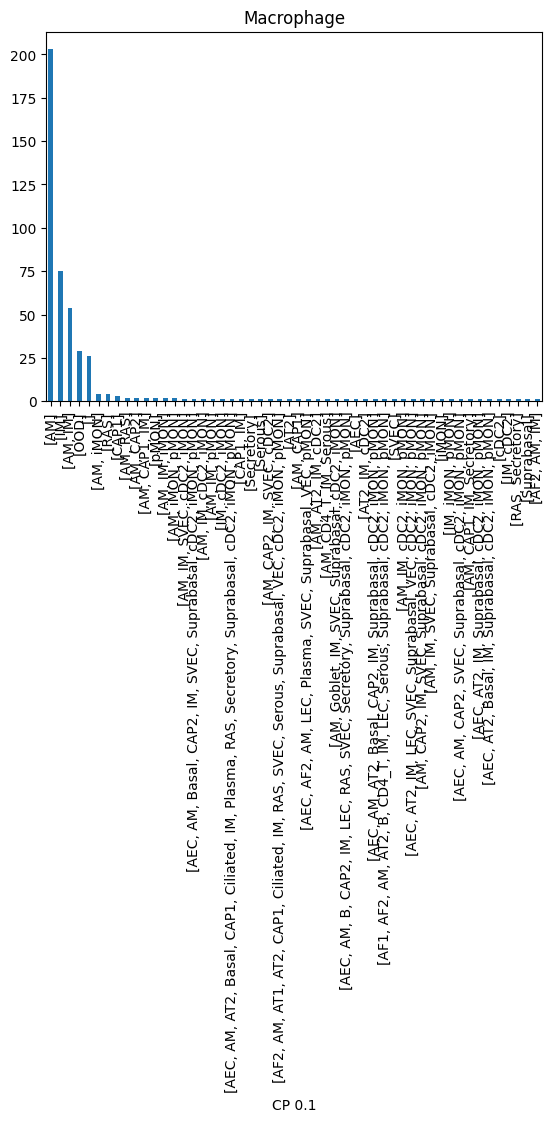

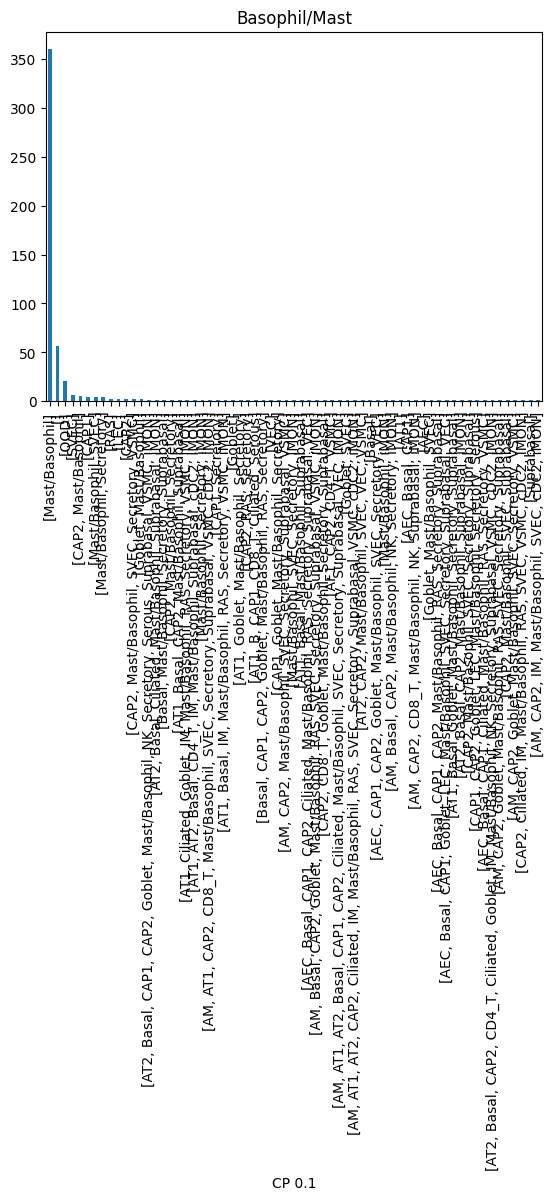

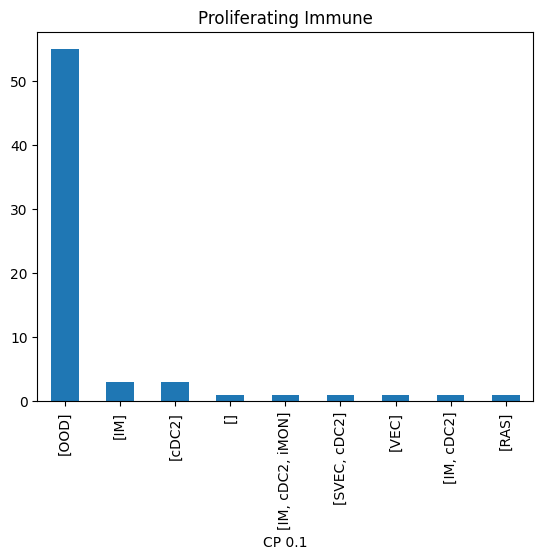

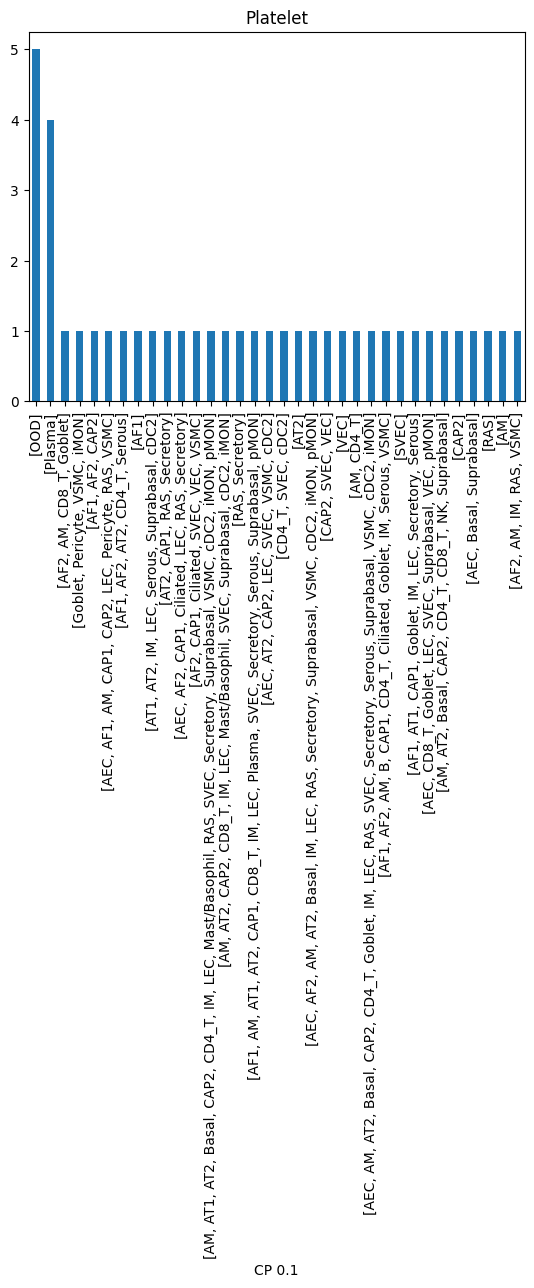

In [9]:
import matplotlib.pyplot as plt

unique_cells = df_results['Original_Cell_Subtype'].unique()

for cell in unique_cells:  
    plt.figure()
    df_ = df_results[df_results['Original_Cell_Subtype'] == cell]
    df_["CP 0.1"].value_counts().plot(kind='bar')
    plt.title(cell)
    plt.show()
    plt.close()